# HEMERA 2019 - Fik 4

## Import data

In [1]:
from fik2 import *

gm_nav, gm = \
    read_airdos_gm_log("/storage/experiments/2019/09_HEMERA/FLIGHT/GM/DATALOG.TXT", mergeruns=True)
cf_nav, cf_candy = \
    read_airdos_cf_log("/storage/experiments/2019/09_HEMERA/FLIGHT/CF/DATALOG.TXT", mergeruns=True)
ff_candy, = \
    read_airdos_ff_log("/storage/experiments/2019/09_HEMERA/FLIGHT/FF/DATALOG.TXT", mergeruns=True)

cf_nav_ = cf_nav.dropna()
ff_candy.index = cf_nav_.index[0] - pd.to_timedelta(cf_nav_.iloc[0]['Time'], unit='sec') \
                 + pd.to_timedelta(ff_candy['Time'], unit='sec')

import aerocalc.std_atm
press2alt = \
    lambda press: aerocalc.std_atm.press2alt(press, press_units='pa',
                                             alt_units='m')

# Read SOCRATES data
fto = '/storage/experiments/2019/09_HEMERA/FLIGHT/Socrat/sdos_hksd.csv'
socrat_candy = pd.read_table(fto, sep=',', header=None,
                             comment='*', engine='python')
socrat_candy['Flux'] = socrat_candy[range(9,53)].sum(axis=1)
socrat_candy['Time'] = pd.to_datetime(socrat_candy[0],unit='s',utc=True)
socrat_candy.set_index('Time',drop=True, inplace=True)

fto = '/storage/experiments/2019/09_HEMERA/FLIGHT/GM-BE/YAXIS.TXT' #  File to Open
df = pd.read_table(fto, sep=',', header=None, comment='*',engine='python' )
df['Flux'] = df[1]
df['Time'] = pd.to_datetime(df[0] + 1567656500,unit='s')
df.set_index('Time',drop=True, inplace=True)
begm = df

In [2]:
gm_nav

,Lat,Lon,Alt,Time,Speed
Time,,,,,
2019-09-05 00:08:49+00:00,67.890041,21.083833,273.1,106.0,0.461148
2019-09-05 00:09:43+00:00,67.889880,21.083429,275.6,160.0,1.716804
2019-09-05 00:10:37+00:00,67.889704,21.083293,255.3,214.0,2.787260
2019-09-05 00:11:30+00:00,67.889704,21.083293,255.3,267.0,0.946372
2019-09-05 00:12:24+00:00,67.890676,21.083843,150.2,321.0,1.970528
...,...,...,...,...,...
2019-09-06 14:59:21+00:00,67.891939,21.085598,316.6,139938.0,0.211128
2019-09-06 15:00:15+00:00,67.891943,21.085557,320.1,139992.0,0.209276
2019-09-06 15:01:09+00:00,67.891966,21.085554,322.8,140046.0,0.209276


## Display raw data
- __CF__ - AIRDOS C with CRY-19 scintillator and SiPM
- __FF__ - SPACEDOS02A 
- __SPACEDOS__ - SPACEDOS01A from Socrat
- __GM__ - G-M Counter with AIRDOS logger
- __GM-BE__ - Another G-M Counter from Belgian's experiment
- Environment sensors:
    * __Temperature__ at the bottom (AIRDOS GM)
    * __Humidity__ at the bottom (AIRDOS GM)
    * __Atmospheric Pressure__ in CANDY box (AIRDOS CF)
    * __Temperature__ in CANDY box (AIRDOS CF)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


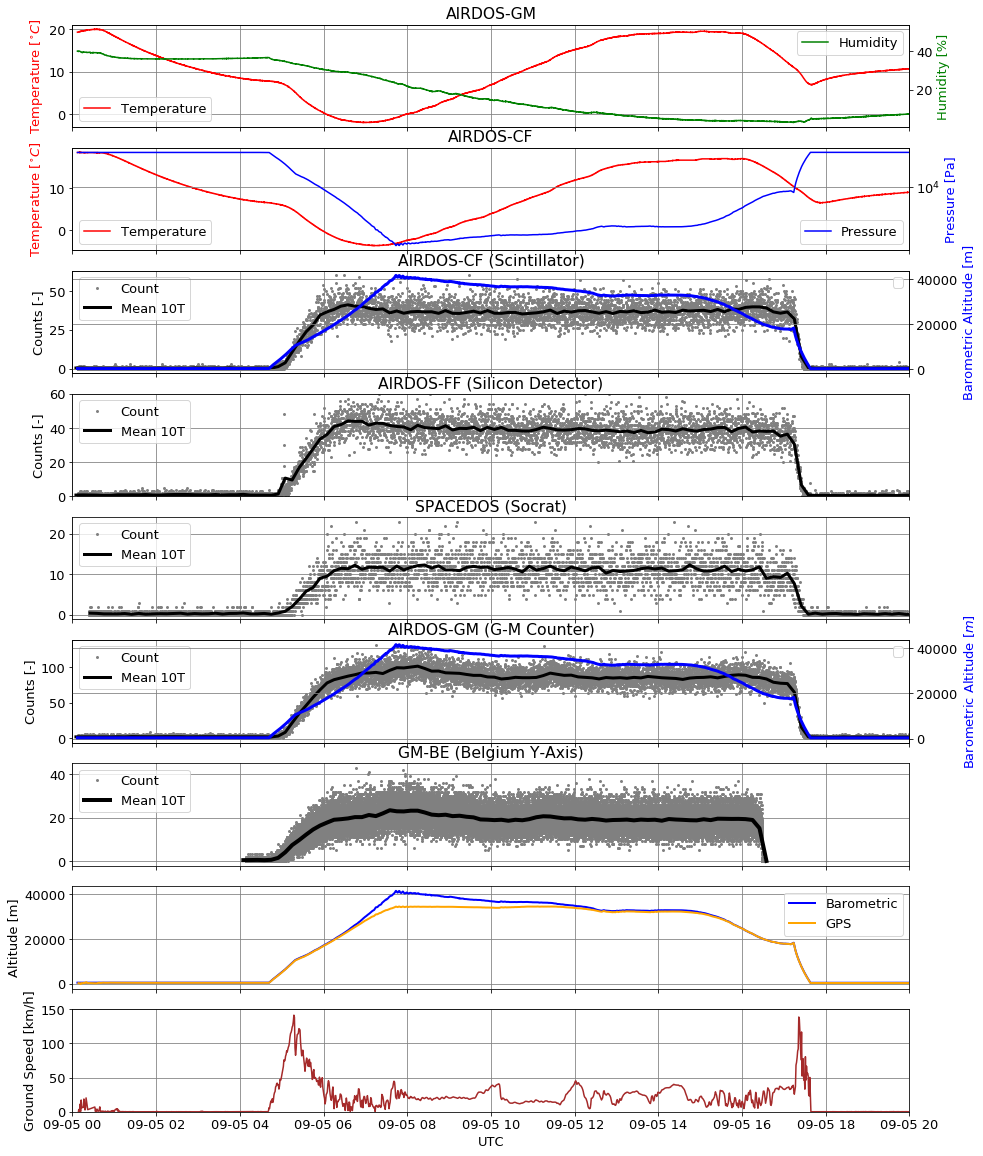

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, (ax1, ax3, ax4, ax5, ax6, ax2, ax7, ax8, ax9) \
    = plt.subplots(figsize=(15, 20), nrows=9, sharex=True)
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

MINUTES = 10
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'

# GM
ax2.set_title("AIRDOS-GM (G-M Counter)")
ax2.set_ylabel('Counts [-]')
ax2.plot(gm.index, gm['GMCount'], linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
ax2.plot(gm['GMCount'].resample(WINDOW, loffset=OFFSET).mean(), label='Mean '+WINDOW, lw=3, color='black')
ax2.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax2.legend(loc=2)
ax1.set_ylabel('Temperature [$^{\circ}C$]', color='red')
ax1.set_title("AIRDOS-GM")
ax1.plot(gm.index, gm['Temp'], color='red', label='Temperature')
ax1.set_xlim('2019-09-05 00:00','2019-09-05 20:00')
ax1.grid(b=True, which='major', color='grey', linestyle='-')
ax1.legend(loc=3)
ax1_twin.set_ylabel('Humidity [%]', color='green')
ax1_twin.plot(gm.index, gm['Humid'], label='Humidity', color='green')
ax1_twin.legend()

ax2_twin.set_ylabel('Barometric Altitude [$m$]', color='blue')
ax2_twin.plot(cf_candy.index, cf_candy['Pressure'].apply(press2alt),
              color='blue', lw=3)
ax2_twin.grid(b=True, which='major', color='grey', linestyle='-', axis='y')
ax2_twin.legend(loc=1)

# CF
spec = np.array(list(map(list, cf_candy['Bins'])))
flux_series = pd.Series(np.sum(spec[:,50:200], axis=1), index=cf_candy.index)

ax4.set_title("AIRDOS-CF (Scintillator)")
ax4.set_ylabel('Counts [-]')
ax4.plot(flux_series.index, flux_series.values, linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
ax4.plot(flux_series.resample(WINDOW, loffset=OFFSET).mean(), label='Mean '+WINDOW, lw=3, color='black')
ax4.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax4.legend(loc=2)
ax3.set_title("AIRDOS-CF")
ax3.set_ylabel('Temperature [$^{\circ}C$]', color='red')
ax3.plot(cf_candy.index, cf_candy['Temp'], label='Temperature', color='red')
ax3.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax3.legend(loc=3)
#ax3_twin.set_ylim(0,2000)
ax3_twin.set_yscale('log')
ax3_twin.set_ylabel('Pressure [Pa]', color='blue')
ax3_twin.plot(cf_candy.index, cf_candy['Pressure'], label='Pressure', color='blue')
ax3_twin.grid(b=True, which='major', color='grey', linestyle='-')
ax3_twin.legend(loc=4)

ax4_twin.set_ylabel('Barometric Altitude [m]', color='blue')
ax4_twin.plot(cf_candy.index, cf_candy['Pressure'].apply(press2alt),
              color='blue', lw=3)
ax4_twin.grid(b=True, which='major', color='grey', linestyle='-')
ax4_twin.legend(loc=1)

# FF
ax5.set_ylim(0, 60)
ax5.set_title('AIRDOS-FF (Silicon Detector)')
ax5.set_ylabel('Counts [-]')
ax5.plot(ff_candy['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
ax5.plot(ff_candy['Flux'].resample(WINDOW, loffset=OFFSET).mean(), lw=3, label='Mean '+WINDOW, color='black')
ax5.grid(b=True, which='major', color='grey', linestyle='-')
ax5.legend(loc=2)

ax6.set_title("SPACEDOS (Socrat)")
ax6.plot(socrat_candy['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
ax6.plot(socrat_candy['Flux'].resample(WINDOW, loffset=OFFSET).mean(), lw=3, label='Mean '+WINDOW, color='black')
#ax6.set_xlim('2019-09-05 00:00','2019-09-05 20:00')
ax6.grid(b=True, which='major', color='grey', linestyle='-')
ax6.legend(loc=2)

ax7.set_title("GM-BE (Belgium Y-Axis)")
ax7.plot(begm['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
ax7.plot(begm['Flux'].resample(WINDOW, loffset=OFFSET).mean(), lw=4, label='Mean '+WINDOW, color='black')
ax7.set_xlim('2019-09-05 00:00','2019-09-05 20:00')
ax7.grid(b=True, which='major', color='grey', linestyle='-')
ax7.legend(loc=2)

ax8.plot(cf_candy.index, cf_candy['Pressure'].apply(press2alt),
         color='blue', lw=2, label='Barometric')
ax8.plot(cf_nav.index, cf_nav['Alt'],
         color='orange', lw=2, label='GPS')
ax8.legend(loc=1)
ax8.set_ylabel('Altitude [m]')
ax8.grid(b=True, which='major', color='grey', linestyle='-')

ax9.plot(cf_nav.index, cf_nav['Speed'], color='brown')
ax9.set_ylabel('Ground Speed [km/h]')
ax9.grid(b=True, which='major', color='grey', linestyle='-')
ax9.set_ylim(0,150)
ax9.set_xlabel('UTC')

None

## Plot Map

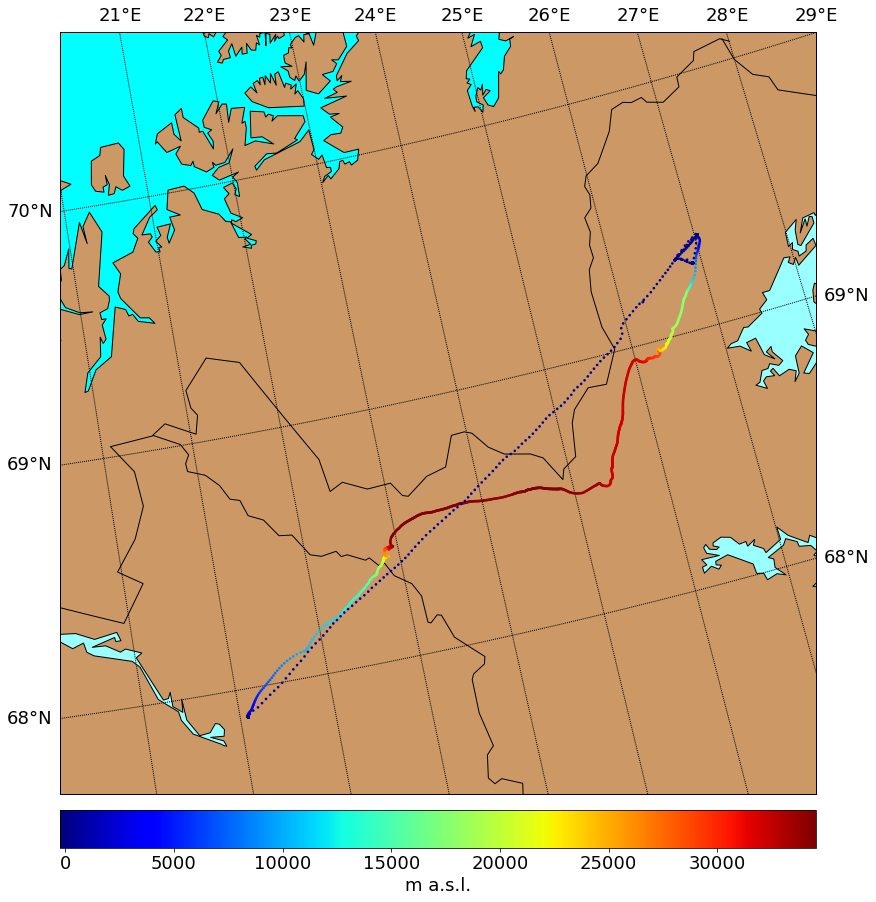

In [4]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import numpy as np

matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(15,15))
m = Basemap(llcrnrlon=19.0, llcrnrlat=67.7, urcrnrlon=29.0,
            urcrnrlat=70.0, epsg = 31284,resolution='i',projection='merc')

x, y = m(list(cf_nav["Lon"].array),list(cf_nav["Lat"].array))
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
#m.shadedrelief(scale=1)
m.drawcountries(linewidth=1)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')

m.drawparallels(np.arange(67.,80.,),labels=[1,1,0,0])
m.drawmeridians(np.arange(19.,30.,),labels=[0,0,1,0])

im1 = m.scatter(x,y,c=list(cf_nav["Alt"]), s=7, marker='o',
                linewidth=0, cmap='jet', zorder=99)
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')
plt.show()

## Plot Spectra

/nix/store/bzbi2yq42fzsi1p0jb86pj9wq4mbapc4-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


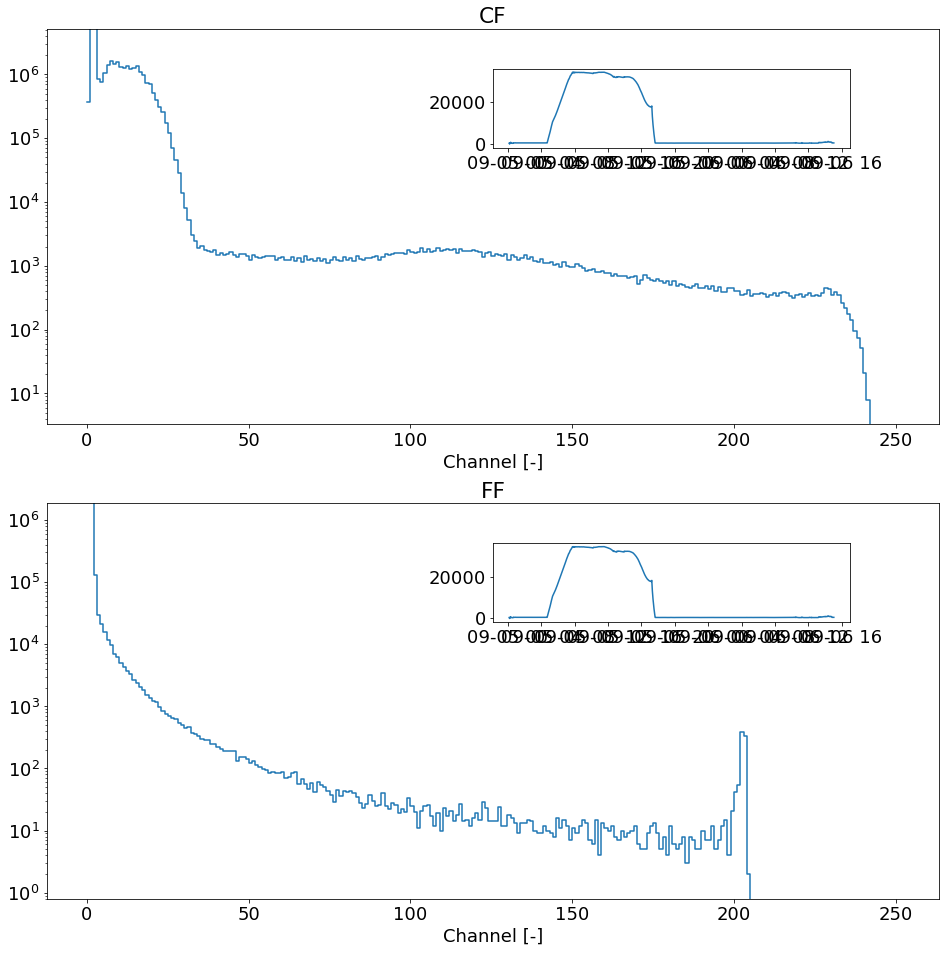

In [5]:
def spectrum_inbetween(tfrom, tto, detectors=None, figsize=None):
    if isinstance(tto, pd.Timedelta):
        tto = tfrom + tto
    
    fig, axes = plt.subplots(
        figsize=(16, 16) if (figsize is None) else figsize,
        nrows=2
    )
    
    for ax in axes.flat:
        n = cf_nav[np.logical_and(
            cf_nav.index > tfrom,
            cf_nav.index < tto
        )]
        ax.inset_axes([0.5, 0.7, 0.4, 0.2]).plot(n.index, n['Alt'])
    
    for candy, axes, title in \
            zip([cf_candy, ff_candy], axes, ["CF", "FF"]):
        c = candy[np.logical_and(
            candy.index > tfrom,
            candy.index < tto
        )]
        spec = np.array(list(map(list, c['Bins'])))
        axes.set_title(title)
        axes.set_yscale('log')
        axes.plot(np.sum(spec, axis=0), drawstyle='steps-post')
        axes.set_ylim(0, np.max(spec)*100)
        axes.set_xlabel('Channel [-]')

spectrum_inbetween(cf_candy.index[0], cf_candy.index[-1])

## Plot CF spectra in time

/nix/store/bzbi2yq42fzsi1p0jb86pj9wq4mbapc4-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


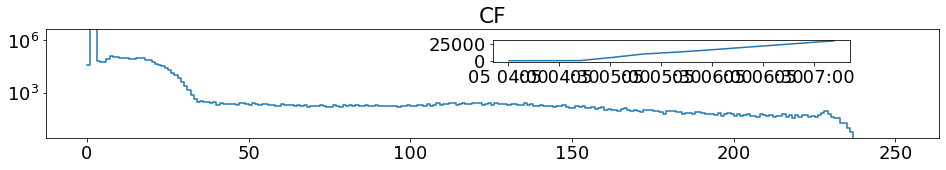

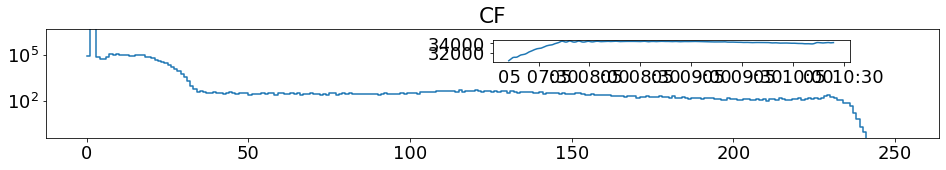

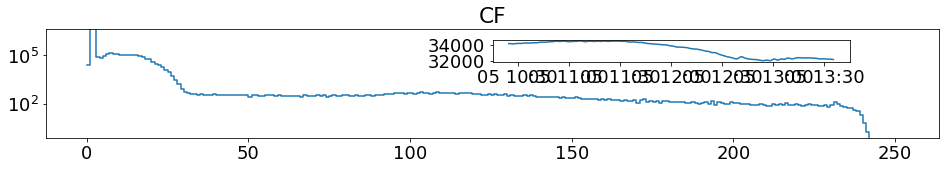

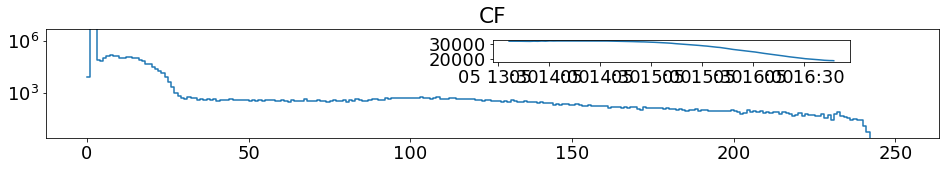

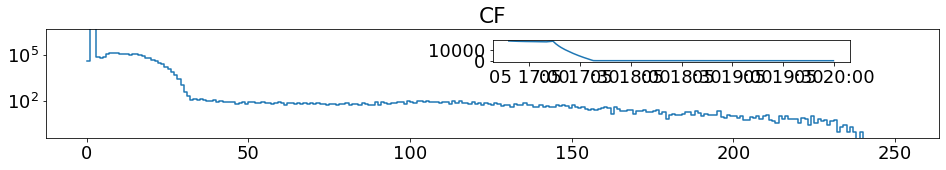

In [6]:
def cf_spectrum_inbetween(tfrom, tto, detectors=None, figsize=None):
    if isinstance(tto, pd.Timedelta):
        tto = tfrom + tto
    
    fig, axes = plt.subplots(
        figsize=(16, 2) if (figsize is None) else figsize,
        nrows=1
    )
    n = cf_nav[tfrom:tto]
    axes.inset_axes([0.5, 0.7, 0.4, 0.2]).plot(n.index, n['Alt'])
    c = cf_candy[tfrom:tto]
    spec = np.array(list(map(list, c['Bins'])))
    axes.set_title("CF")
    axes.set_yscale('log')
    axes.plot(np.sum(spec, axis=0), drawstyle='steps-post')
    axes.set_ylim(0, np.max(spec)*100)

N = 5
s = pd.Timestamp(year=2019, month=9, day=5, hour=4, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=20, minute=0, tz='UTC')
delta = e - s
m = delta/N
for i in range(N):
    cf_spectrum_inbetween(s+m*i, s+m*(i+1))

# Vertical Profiles

In [7]:
import aerocalc
press2alt = \
    lambda press: aerocalc.std_atm.press2alt(press, press_units='pa',
                                             alt_units='m')

MINUTES = 10
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'

def pressure_for(m):
    alt = cf_candy['Pressure']
    return alt.reindex(alt.index.union(m.index)).interpolate(method='index', limit=5).reindex(m.index)

def vertical_profile(tfrom, tto, separate=False, axes=None):
    host = None
    if axes is None and not separate:
        fig = plt.figure(figsize=(10, 10))
        host = fig.add_subplot(111)
        par1 = host.twiny()
        par2 = host.twiny()
        par3 = host.twiny()
        axes = [host, par1, par2, par3]
    
    cf_spec = np.array(list(map(list, cf_candy['Bins'])))
    # Calculate flux from flat region
    cf_flux = pd.Series(np.sum(cf_spec[:,50:200], axis=1),
                        index=cf_candy.index)
    flux_series = [
        cf_flux,
        ff_candy['Flux'],
        gm['GMCount'],
        socrat_candy['Flux']
    ]
    
    lns = []
    for flux, ax, label, col in zip(flux_series,
                               axes,
                               ["AIRDOS-CF", "AIRDOS-FF", "AIRDOS-GM", "SPACEDOS"],
                               [plt.cm.viridis(0), plt.cm.viridis(0.5),
                                plt.cm.viridis(.9), plt.cm.viridis(.25)]):
        resample = flux[tfrom:tto].resample(WINDOW, loffset=OFFSET)
        mean = resample.mean()
        
        if separate and axes is None:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111)
            ax.set_title(label)

        ax.set_ylabel("Altitude [m]")
        ax.set_xlabel("Flux / Counts [-]", color=col)
        r = ax.errorbar(mean, pressure_for(mean).apply(press2alt), label=label,
                        xerr=resample.sem()*2, fmt='o', color=col)
        lns.append(r)

    if host is not None:
        par2.spines['top'].set_position(('outward', 60))
        par3.spines['top'].set_position(('outward', 120))
    if not separate:
        axes[0].legend(handles=lns, loc='upper left')

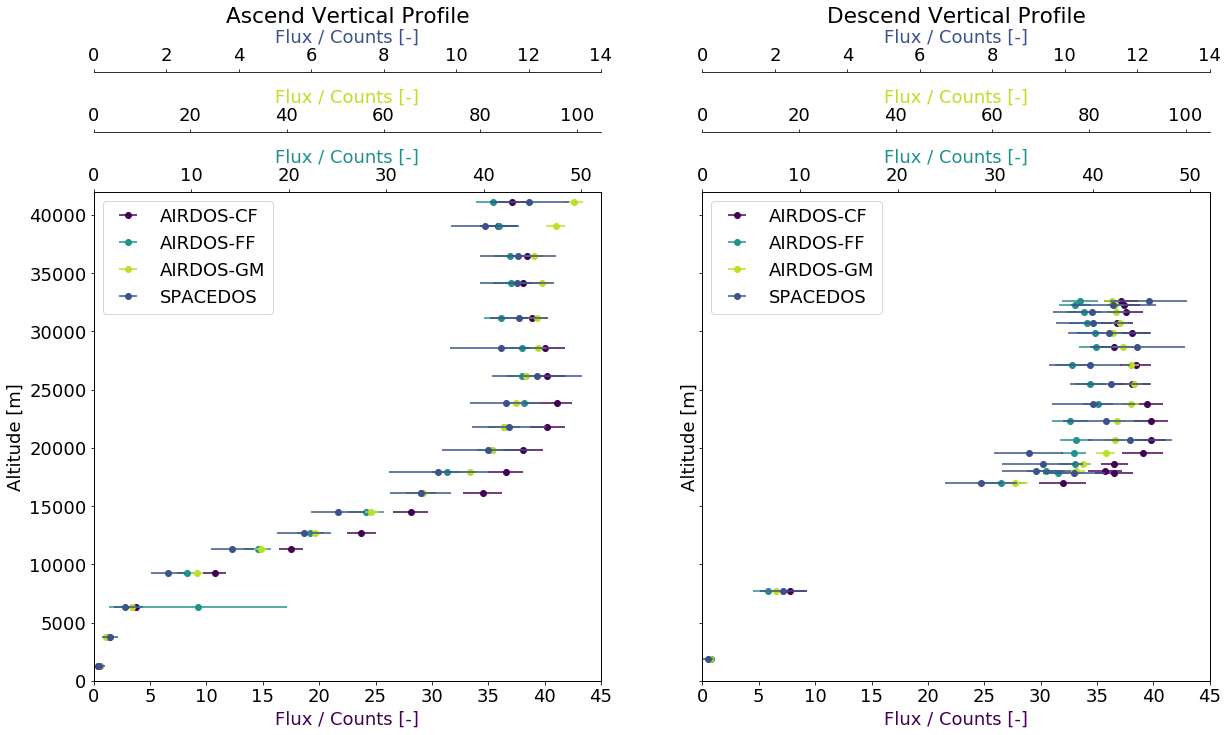

In [8]:
CF_XLIM = (0, 45)
FF_XLIM = (0, 52)
GM_XLIM = (0, 105)
SD_XLIM = (0, 14)

ALT_YLIM = (0, 42000)

fig, (host1, host2) = plt.subplots(figsize=(20, 9), ncols=2, sharey=True)

par11 = host1.twiny()
par12 = host1.twiny()
par13 = host1.twiny()
par12.spines['top'].set_position(('outward', 60))
par13.spines['top'].set_position(('outward', 120))
host1.set_xlim(*CF_XLIM)
par11.set_xlim(*FF_XLIM)
par12.set_xlim(*GM_XLIM)
par13.set_xlim(*SD_XLIM)
host1.set_ylim(*ALT_YLIM)

par21 = host2.twiny()
par22 = host2.twiny()
par23 = host2.twiny()
par22.spines['top'].set_position(('outward', 60))
par23.spines['top'].set_position(('outward', 120))
host2.set_xlim(*CF_XLIM)
par21.set_xlim(*FF_XLIM)
par22.set_xlim(*GM_XLIM)
par23.set_xlim(*SD_XLIM)
host2.set_ylim(*ALT_YLIM)

# Ascend
s = pd.Timestamp(year=2019, month=9, day=5, hour=4, minute=40, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=7, minute=50, tz='UTC')
vertical_profile(s, e, axes=[host1, par11, par12, par13])
host1.set_title("Ascend Vertical Profile")

# Descend
s = pd.Timestamp(year=2019, month=9, day=5, hour=14, minute=40, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=17, minute=40, tz='UTC')
vertical_profile(s, e, axes=[host2, par21, par22, par23])
host2.set_title("Descend Vertical Profile")
None

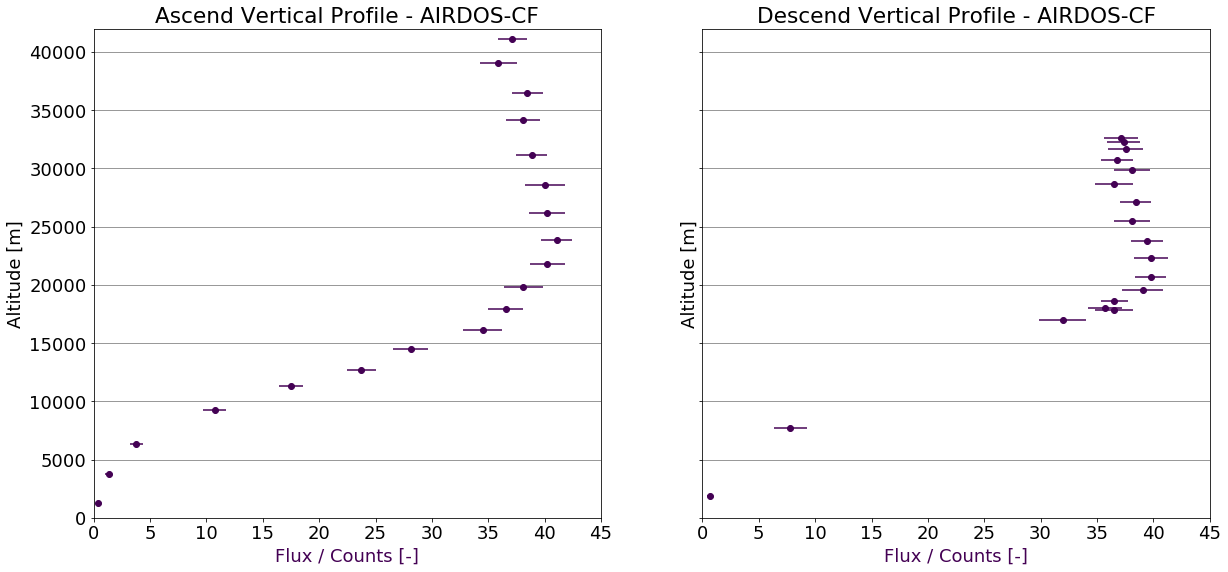

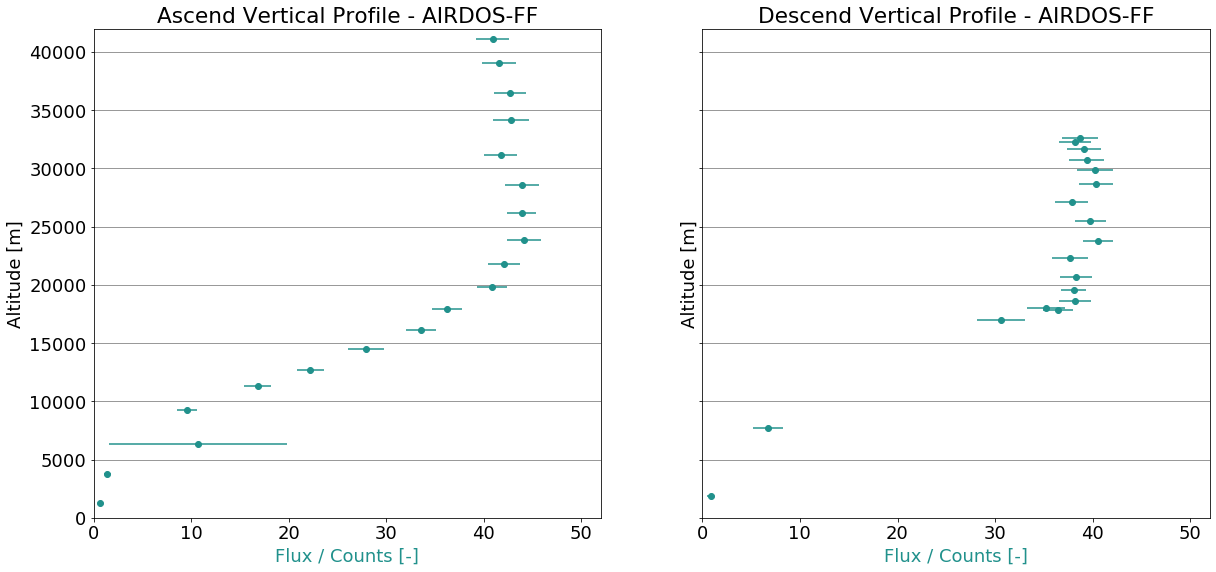

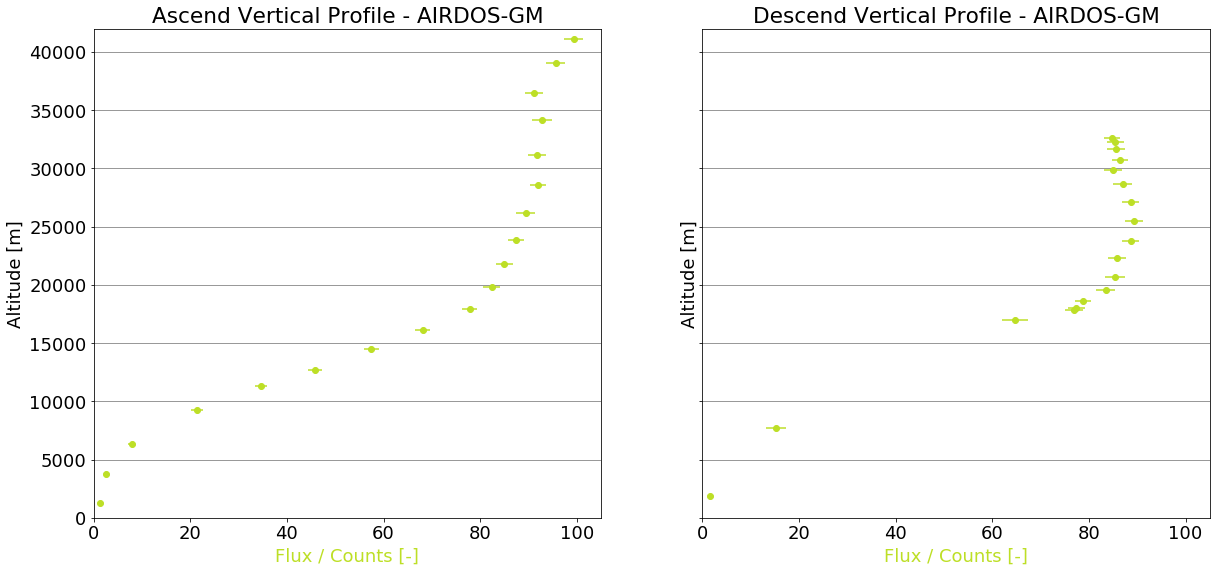

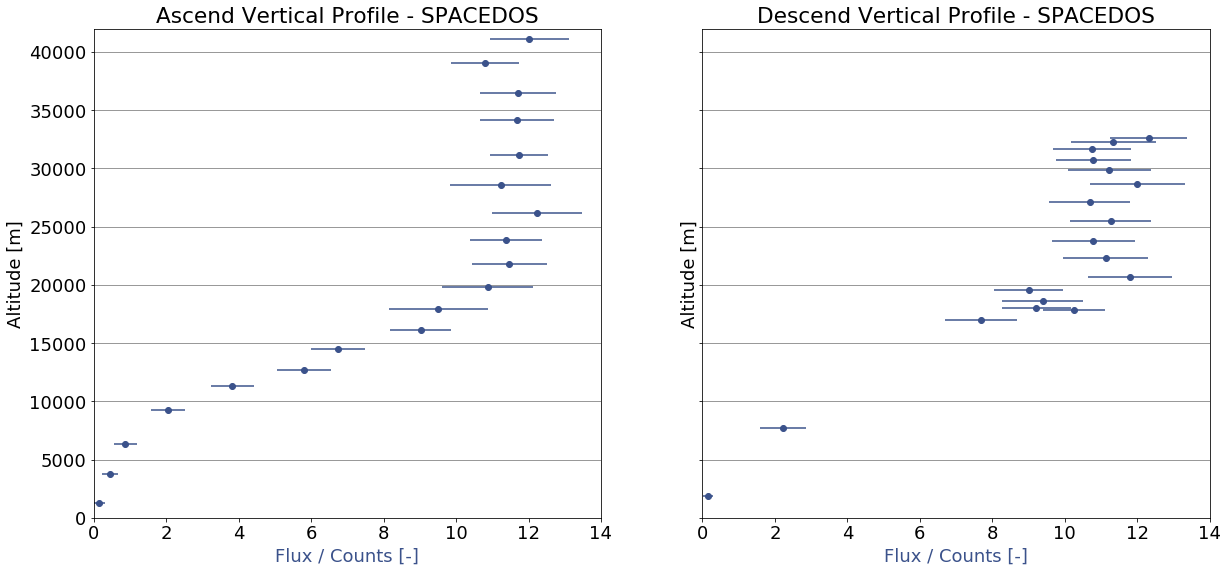

In [9]:
ascend_axes=[]
descend_axes=[]

for title, xlimits in zip(["AIRDOS-CF", "AIRDOS-FF", "AIRDOS-GM", "SPACEDOS"],
                          [CF_XLIM, FF_XLIM, GM_XLIM, SD_XLIM]):
    fig, (host1, host2) = plt.subplots(figsize=(20, 9), ncols=2, sharey=True)
    host1.set_xlim(*xlimits)
    host2.set_xlim(*xlimits)
    host1.set_ylim(*ALT_YLIM)
    host1.set_title("Ascend Vertical Profile - %s" % title)
    host2.set_title("Descend Vertical Profile - %s" % title)
    host1.grid(b=True, which='major', color='grey', linestyle='-', axis='y')
    host2.grid(b=True, which='major', color='grey', linestyle='-', axis='y')
    ascend_axes.append(host1)
    descend_axes.append(host2)

# Ascend
s = pd.Timestamp(year=2019, month=9, day=5, hour=4, minute=40, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=7, minute=50, tz='UTC')
vertical_profile(s, e, axes=ascend_axes, separate=True)

# Descend
s = pd.Timestamp(year=2019, month=9, day=5, hour=14, minute=40, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=17, minute=40, tz='UTC')
vertical_profile(s, e, axes=descend_axes, separate=True)

## Detail of vertical profiles

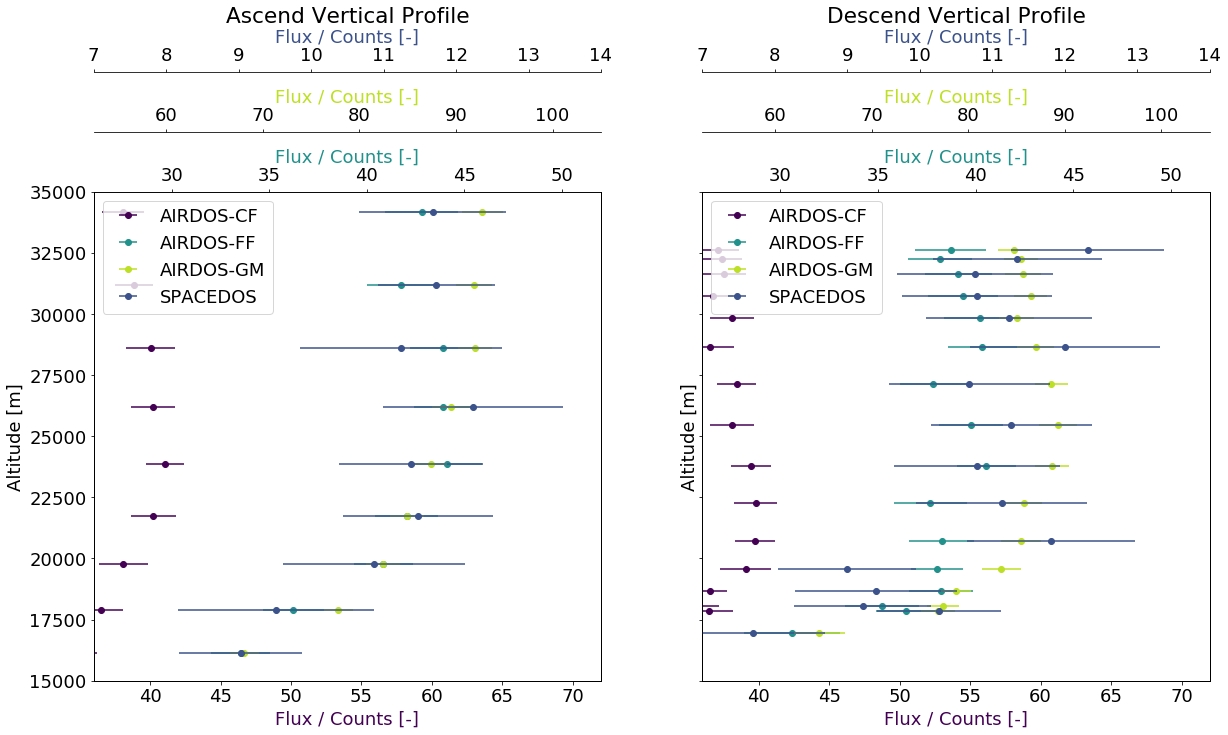

In [10]:
CF_XLIM = (72/2, 72)
FF_XLIM = (52/2, 52)
GM_XLIM = (105/2, 105)
SD_XLIM = (14/2, 14)

ALT_YLIM = (15000, 35000)

fig, (host1, host2) = plt.subplots(figsize=(20, 9), ncols=2, sharey=True)

par11 = host1.twiny()
par12 = host1.twiny()
par13 = host1.twiny()
par12.spines['top'].set_position(('outward', 60))
par13.spines['top'].set_position(('outward', 120))
host1.set_xlim(*CF_XLIM)
par11.set_xlim(*FF_XLIM)
par12.set_xlim(*GM_XLIM)
par13.set_xlim(*SD_XLIM)
host1.set_ylim(*ALT_YLIM)

par21 = host2.twiny()
par22 = host2.twiny()
par23 = host2.twiny()
par22.spines['top'].set_position(('outward', 60))
par23.spines['top'].set_position(('outward', 120))
host2.set_xlim(*CF_XLIM)
par21.set_xlim(*FF_XLIM)
par22.set_xlim(*GM_XLIM)
par23.set_xlim(*SD_XLIM)
host2.set_ylim(*ALT_YLIM)

# Ascend
s = pd.Timestamp(year=2019, month=9, day=5, hour=4, minute=40, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=7, minute=50, tz='UTC')
vertical_profile(s, e, axes=[host1, par11, par12, par13])
host1.set_title("Ascend Vertical Profile")

# Descend
s = pd.Timestamp(year=2019, month=9, day=5, hour=14, minute=40, tz='UTC')
e = pd.Timestamp(year=2019, month=9, day=5, hour=17, minute=40, tz='UTC')
vertical_profile(s, e, axes=[host2, par21, par22, par23])
host2.set_title("Descend Vertical Profile")
None

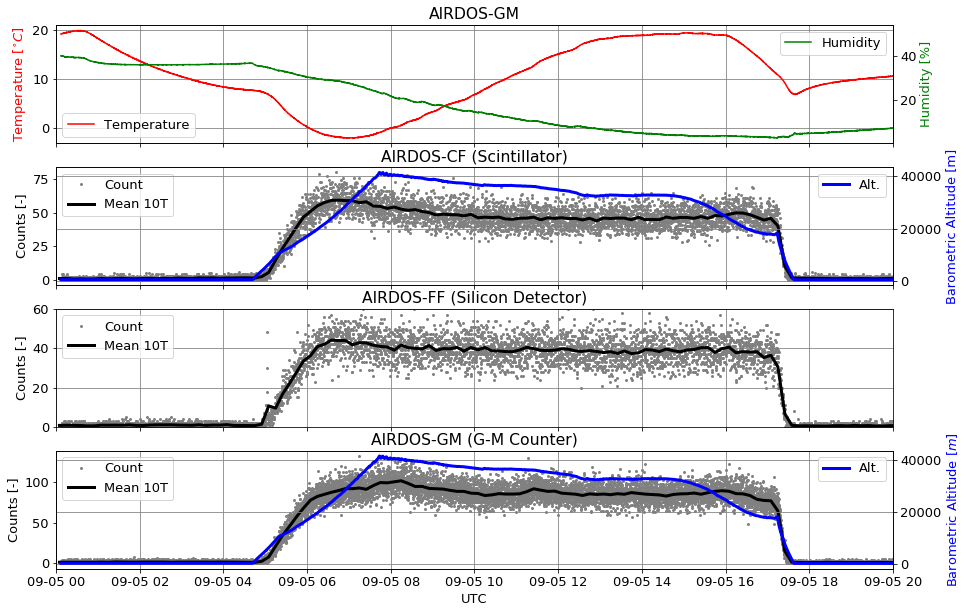

In [11]:
matplotlib.rcParams.update({'font.size': 13})

fig, (ax1, ax4, ax5,  ax2) \
    = plt.subplots(figsize=(15, 10), nrows=4, sharex=True)
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

MINUTES = 10
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'

ax1.set_ylabel('Temperature [$^{\circ}C$]', color='red')
ax1.set_title("AIRDOS-GM")
ax1.plot(gm.index, gm['Temp'], color='red', label='Temperature')
ax1.set_xlim('2019-09-05 00:00','2019-09-05 20:00')
ax1.grid(b=True, which='major', color='grey', linestyle='-')
ax1.legend(loc=3)
ax1_twin.set_ylabel('Humidity [%]', color='green')
ax1_twin.plot(gm.index, gm['Humid'], label='Humidity', color='green')
ax1_twin.legend()

# GM
ax2.set_title("AIRDOS-GM (G-M Counter)")
ax2.set_ylabel('Counts [-]')
ax2.plot(gm.index, gm['GMCount'], linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
ax2.plot(gm['GMCount'].resample(WINDOW, loffset=OFFSET).mean(), label='Mean '+WINDOW, lw=3, color='black')
ax2.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax2.legend(loc=2)

ax2_twin.set_ylabel('Barometric Altitude [$m$]', color='blue')
ax2_twin.plot(cf_candy.index, cf_candy['Pressure'].apply(press2alt),
              color='blue', lw=3, label='Alt.')
ax2_twin.grid(b=True, which='major', color='grey', linestyle='-', axis='y')
ax2_twin.legend(loc=1)

# CF
spec = np.array(list(map(list, cf_candy['Bins'])))
flux_series = pd.Series(np.sum(spec[:,30:], axis=1), index=cf_candy.index)

ax4.set_title("AIRDOS-CF (Scintillator)")
ax4.set_ylabel('Counts [-]')
ax4.plot(flux_series.index, flux_series.values, linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
ax4.plot(flux_series.resample(WINDOW, loffset=OFFSET).mean(), label='Mean '+WINDOW, lw=3, color='black')
ax4.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax4.legend(loc=2)

ax4_twin.set_ylabel('Barometric Altitude [m]', color='blue')
ax4_twin.plot(cf_candy.index, cf_candy['Pressure'].apply(press2alt),
              color='blue', lw=3, label='Alt.')
ax4_twin.grid(b=True, which='major', color='grey', linestyle='-')
ax4_twin.legend(loc=1)

ax5.set_ylim(0, 60)
ax5.set_title('AIRDOS-FF (Silicon Detector)')
ax5.set_ylabel('Counts [-]')
ax5.plot(ff_candy['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
ax5.plot(ff_candy['Flux'].resample(WINDOW, loffset=OFFSET).mean(), lw=3, label='Mean '+WINDOW, color='black')
ax5.grid(b=True, which='major', color='grey', linestyle='-')
ax5.legend(loc=2)

ax2.set_xlabel('UTC')

None

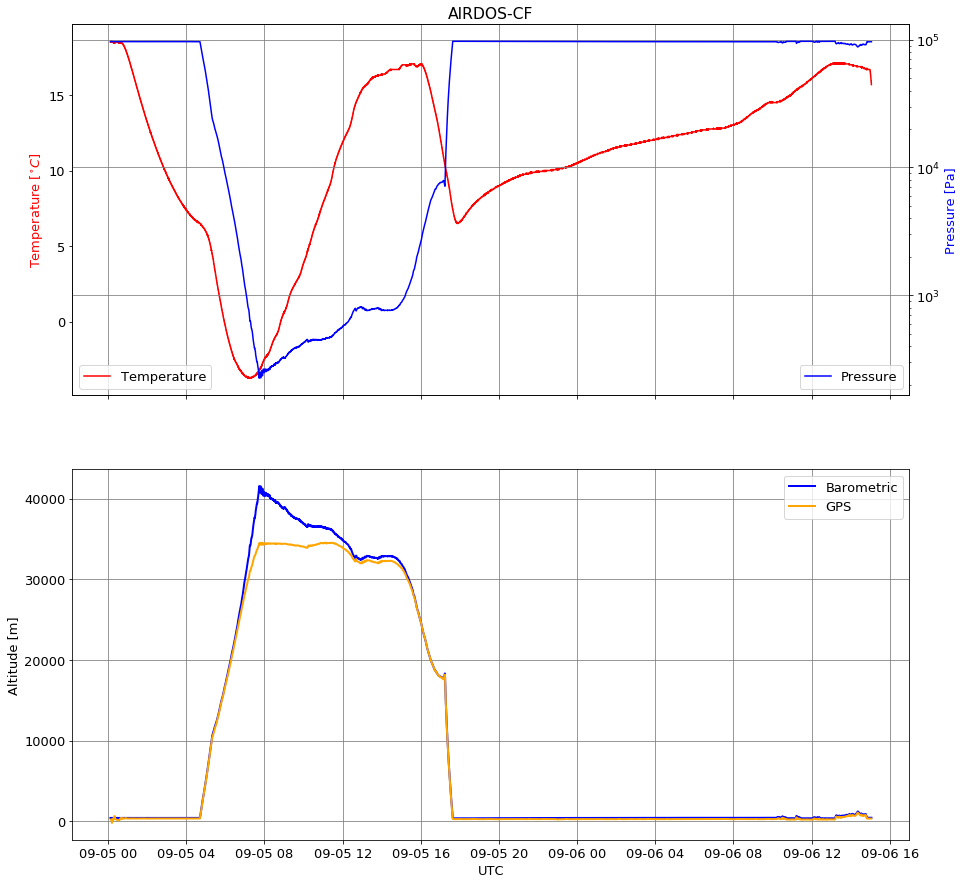

In [12]:
import matplotlib  
matplotlib.rcParams.update({'font.size': 13})

fig, (ax3, ax8) \
    = plt.subplots(figsize=(15, 15), nrows=2, sharex=True)
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

MINUTES = 10
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'

# CF
spec = np.array(list(map(list, cf_candy['Bins'])))
flux_series = pd.Series(np.sum(spec[:,50:200], axis=1), index=cf_candy.index)

ax3.set_title("AIRDOS-CF")
ax3.set_ylabel('Temperature [$^{\circ}C$]', color='red')
ax3.plot(cf_candy.index, cf_candy['Temp'], label='Temperature', color='red')
ax3.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax3.legend(loc=3)
#ax3_twin.set_ylim(0,2000)
ax3_twin.set_yscale('log')
ax3_twin.set_ylabel('Pressure [Pa]', color='blue')
ax3_twin.plot(cf_candy.index, cf_candy['Pressure'], label='Pressure', color='blue')
ax3_twin.grid(b=True, which='major', color='grey', linestyle='-')
ax3_twin.legend(loc=4)


ax8.plot(cf_candy.index, cf_candy['Pressure'].apply(press2alt),
         color='blue', lw=2, label='Barometric')
ax8.plot(cf_nav.index, cf_nav['Alt'],
         color='orange', lw=2, label='GPS')
ax8.legend(loc=1)
ax8.set_ylabel('Altitude [m]')
ax8.grid(b=True, which='major', color='grey', linestyle='-')

ax8.set_xlabel('UTC')

None

/nix/store/bzbi2yq42fzsi1p0jb86pj9wq4mbapc4-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


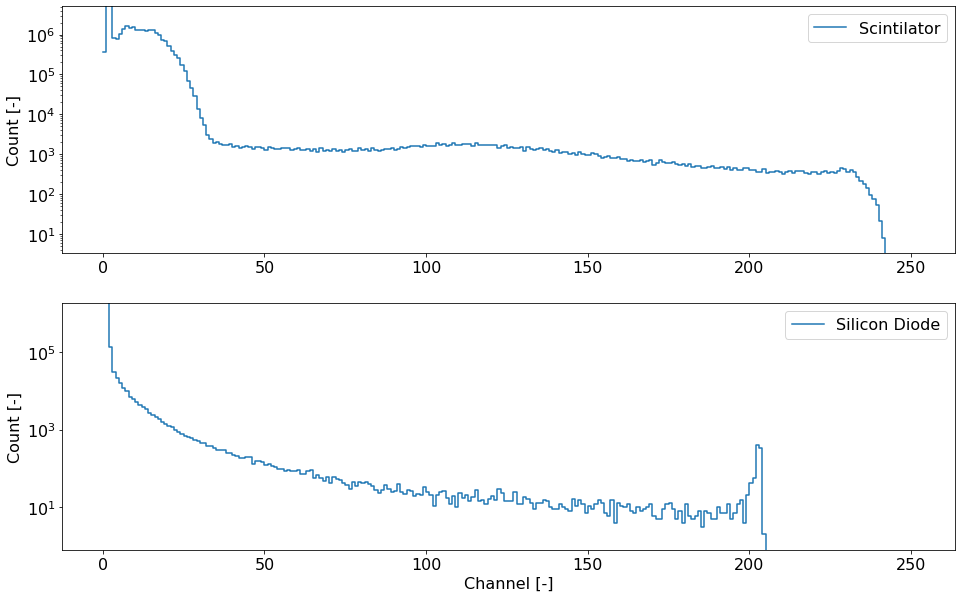

In [13]:
matplotlib.rcParams.update({'font.size': 16})

def spectrum_inbetween(tfrom, tto, detectors=None, figsize=None):
    if isinstance(tto, pd.Timedelta):
        tto = tfrom + tto
    
    fig, axes = plt.subplots(
        figsize=(16, 10) if (figsize is None) else figsize,
        nrows=2
    )
    
    for candy, axes, title in \
            zip([cf_candy, ff_candy], axes, ["Scintilator", "Silicon Diode"]):
        c = candy[np.logical_and(
            candy.index > tfrom,
            candy.index < tto
        )]
        spec = np.array(list(map(list, c['Bins'])))
        #axes.set_title(title)
        axes.set_yscale('log')
        axes.plot(np.sum(spec, axis=0), drawstyle='steps-post', label=title)
        axes.set_ylim(0, np.max(spec)*100)
        axes.set_ylabel('Count [-]')
        axes.legend()
    axes.set_xlabel('Channel [-]')

spectrum_inbetween(cf_candy.index[0], cf_candy.index[-1])

In [14]:
fto = '/storage/experiments/2019/09_HEMERA/FLIGHT/CARI/HEMERA_CARI7.csv' #  File to Open
df = pd.read_table(fto, sep=',', engine='python' )

FileNotFoundError: [Errno 2] No such file or directory: '/storage/experiments/2019/09_HEMERA/FLIGHT/CARI/HEMERA_CARI7.csv'

In [ ]:
fig, (ax1, ax2, ax3,  ax4, ax5, ax6) \
    = plt.subplots(figsize=(15, 20), nrows=6, sharex=True)
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()
ax5_twin = ax5.twinx()

ax1.plot(df['MINUTES'], df['ALTITUDE(km)'], c='blue')
ax1.set_ylabel('Altitude [km]', color='blue')
ax1_twin.plot(df['MINUTES'], df['ICRU_H*(10)_Ambient_Dose_Equivalent(microSv)'], c='r')
ax1_twin.set_ylabel('H*10 [uSV]', color='r')
ax1_twin.legend()
ax1.grid(b=True, which='major', color='grey', linestyle='-')

ax2.plot(df['MINUTES'], df['ALTITUDE(km)'], c='blue')
ax2.set_ylabel('Altitude [km]', color='blue')
ax2_twin.plot(df['MINUTES'], df['electron_flux'], c='r')
ax2_twin.set_ylabel('flux', color='r')
ax2_twin.legend()
ax2.grid(b=True, which='major', color='grey', linestyle='-')

ax3.plot(df['MINUTES'], df['ALTITUDE(km)'], c='blue')
ax3.set_ylabel('Altitude [km]', color='blue')
ax3_twin.plot(df['MINUTES'], df['photon_flux'], c='r')
ax3_twin.set_ylabel('flux', color='r')
ax3_twin.legend()
ax3.grid(b=True, which='major', color='grey', linestyle='-')

ax4.plot(df['MINUTES'], df['ALTITUDE(km)'], c='blue')
ax4.set_ylabel('Altitude [km]', color='blue')
ax4_twin.plot(df['MINUTES'], df['neutron_flux(p/sq.cm)'], c='r')
ax4_twin.set_ylabel('flux', color='r')
ax4_twin.legend()
ax4.grid(b=True, which='major', color='grey', linestyle='-')

ax5.plot(df['MINUTES'], df['ALTITUDE(km)'], c='blue')
ax5.set_ylabel('Altitude [km]', color='blue')
ax5_twin.plot(df['MINUTES'], df['proton_flux'], c='r')
ax5_twin.set_ylabel('flux', color='r')
ax5_twin.legend()
ax5.grid(b=True, which='major', color='grey', linestyle='-')

MINUTES = 10
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'
base = ff_candy.index[0]
ff_candy['tim'] =  ((ff_candy.index-base).total_seconds() / 60) - 70

ax6.set_ylim(0, 60)
ax6.set_xlim(0, 1100)
ax6.set_title('AIRDOS-FF (Silicon Detector)')
ax6.set_xlabel('time [minutes]')
ax6.set_ylabel('Counts [-]')
#ax6.plot((ff_candy.index-base).total_seconds() / 60, ff_candy['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
ax6.plot(ff_candy['tim'].resample(WINDOW, loffset=OFFSET).mean(), ff_candy['Flux'].resample(WINDOW, loffset=OFFSET).mean(), lw=3, label='Mean '+WINDOW, color='black')
ax6.grid(b=True, which='major', color='grey', linestyle='-')
ax6.legend(loc=2)

#df.iloc[0:10,10:20]
None

In [ ]:
base = ff_candy.index[0]
(ff_candy.index-base).total_seconds() / 60
plt.plot((ff_candy.index-base).total_seconds() / 60, ff_candy['Flux'])
